تعداد کلاس‌ها: 4
لیست کلاس‌ها: ['bump', 'crack', 'gap', 'unknowm']
تعداد داده‌های آموزشی: 798
تعداد داده‌های تست: 63
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.4641 - loss: 0.1991 - val_accuracy: 0.6000 - val_loss: 2.8201
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.4090 - loss: 0.0580 - val_accuracy: 0.3375 - val_loss: 0.4347
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.4940 - loss: 0.0287 - val_accuracy: 0.2875 - val_loss: 1.5585
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.4794 - loss: 0.0339 - val_accuracy: 0.1875 - val_loss: 0.8145
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.5635 - loss: 0.0461 - val_accuracy: 0.2750 - val_loss: 1.0917
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1895 - loss: 0.7169
خطای تست (Loss): 0.7424
دقت تست (Accuracy): 0.1905
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


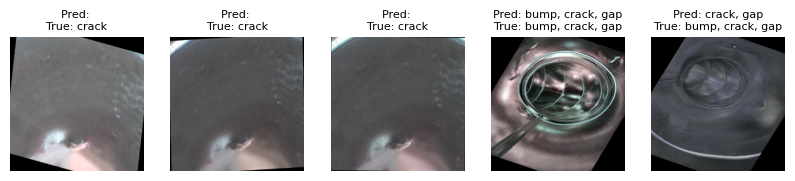

Saved artifact at '/tmp/tmpq32ied92'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138955110593360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111384848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955110595664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955110595472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955110596432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111384080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111383312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111385232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955111385040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13895511138561

In [ ]:
import os
import cv2
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

dataset_path = "bump_on"
test_path = "testt/test"

classes_file = os.path.join(dataset_path, "classes.txt")
with open(classes_file, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
num_classes = len(class_names)

print(f"تعداد کلاس‌ها: {num_classes}")
print("لیست کلاس‌ها:", class_names)

img_size = (224, 224)

# تابع بارگذاری تصاویر با فیلتر شماره داخل پرانتز
def load_images(folder, labeled=True):
    images, labels = [], []

    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            match = re.search(r'\((\d+)\)', file)
            if match:
                num_in_parentheses = int(match.group(1))
                if num_in_parentheses > 20:
                    continue  # اگر شماره بیشتر از 20 است، این فایل را نادیده بگیر

            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue

            img = cv2.resize(img, img_size) / 255.0
            images.append(img)

            if labeled:
                txt_path = img_path.replace(".jpg", ".txt")
                label_vector = np.zeros(num_classes)

                if os.path.exists(txt_path):
                    with open(txt_path, "r") as f:
                        for line in f.readlines():
                            try:
                                class_id = int(line.split()[0])
                                if class_id != 3:
                                    label_vector[class_id] = 1
                            except:
                                pass

                labels.append(label_vector)

    if labeled:
        return np.array(images), np.array(labels)
    else:
        return np.array(images)

X_train, y_train = load_images(dataset_path, labeled=True)
X_test, y_test = load_images(test_path, labeled=True)

print(f"تعداد داده‌های آموزشی: {X_train.shape[0]}")
print(f"تعداد داده‌های تست: {X_test.shape[0]}")

# مدل MobileNetV2 با تعداد پارامترهای کمتر
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation="relu")(x)  # تعداد نودها کاهش یافته
x = Dense(num_classes, activation="sigmoid")(x)  # استفاده از سیگموید برای چندکلاسه

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=16)  # استفاده از batch_size برای کاهش مصرف رم

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"خطای تست (Loss): {test_loss:.4f}")
print(f"دقت تست (Accuracy): {test_accuracy:.4f}")

predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

plt.figure(figsize=(10, 5))
for i in range(min(5, len(X_test))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i])

    true_classes = [class_names[j] for j in range(num_classes) if y_test[i][j] == 1]
    pred_classes = [class_names[j] for j in range(num_classes) if predicted_labels[i][j] == 1]

    title_text = f"Pred: {', '.join(pred_classes)}\nTrue: {', '.join(true_classes)}"
    plt.title(title_text, fontsize=8)

    plt.axis("off")

plt.show()

model.save("bump_detector.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("bump_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("مدل TFLite ذخیره شد: bump_detector.tflite")
